In [2]:
import numpy as np
import torch
from tqdm import tqdm
import json
import os
import matplotlib.pyplot as plt


### Raw garage pos process

In [39]:
f = open('2022/garage_pos_raw.json', 'r')
p = json.load(f)['car_park']
f.close()

res = {}

for g in p:
    id = g['park_id']
    res[id] = g

f = open('2022/garage_pos.json', 'w')
f.write(json.dumps(res))
f.close()

### Peek

In [40]:
path = '2022/garage'
dates = os.listdir(path)
for date in dates[:1]:
    times = os.listdir(os.path.join(path, date))
    for file in times[:1]:
        f = open(os.path.join(path, date, file), 'r')
        p = json.loads(f.read())['car_park']
        f.close()

In [41]:
len(p)

350

In [42]:
i = 233
print(p[i])
print(res[p[i]['park_id']])

{'park_id': 'tdc32p4', 'vehicle_type': [{'type': 'P', 'service_category': [{'category': 'HOURLY', 'vacancy_type': 'A', 'vacancy': -1, 'lastupdate': '2021-12-31 16:18:03'}]}, {'type': 'L', 'service_category': [{'category': 'HOURLY', 'vacancy_type': 'A', 'vacancy': -1, 'lastupdate': '2021-12-31 16:18:03'}]}, {'type': 'H', 'service_category': [{'category': 'HOURLY', 'vacancy_type': 'A', 'vacancy': -1, 'lastupdate': '2021-12-31 16:18:03'}]}, {'type': 'M', 'service_category': [{'category': 'HOURLY', 'vacancy_type': 'A', 'vacancy': -1, 'lastupdate': '2021-12-31 16:18:03'}]}]}
{'park_id': 'tdc32p4', 'name_en': 'Pok Hong Estate', 'name_tc': '博康邨', 'name_sc': '博康邨', 'displayAddress_en': 'Sha Kok Street, Shatin, New Territories', 'displayAddress_tc': '新界沙田沙角街', 'displayAddress_sc': '新界沙田沙角街', 'latitude': 22.37539675, 'longitude': 114.19316679, 'district_en': 'Sha Tin', 'district_tc': '沙田區', 'district_sc': '沙田区', 'contactNo': '2512 9611', 'opening_status': 'OPEN', 'height': 1.9, 'remark_en': 'Hei

In [43]:
type_dict = {}
for g in p:
    for t in g['vehicle_type']:
        key = t['type']
        vac = t['service_category'][0]['vacancy']
        if key in type_dict:
            type_dict[key][0] += 1
            type_dict[key][1] += vac
        else:
            type_dict[key] = [1, vac]


for t in type_dict.keys():
    stat = type_dict[t]
    print(t, stat[0], stat[1] / stat[0])

P 348 15.304597701149426
M 34 1.588235294117647
L 20 1.15
B 12 1.4166666666666667
H 8 -0.5
C 5 -0.6
N 2 -1.0
O 1 11.0


### select usable ids

In [44]:
usable_ids = set(res.keys())

path = '2022/garage'
dates = os.listdir(path)
for date in tqdm(dates[:]):
    times = os.listdir(os.path.join(path, date))
    usable_ids_this_file = set()
    for file in times[:]:
        f = open(os.path.join(path, date, file), 'r')
        try:
            p = json.loads(f.read())['car_park']
        except:
            print(os.path.join(path, date, file))
        f.close()
        
        for g in p:
            for t in g['vehicle_type']:
                if t['type'] == 'P':
                    usable_ids_this_file.add(g['park_id'])
                    break
    
    # appears in every file
    usable_ids &= usable_ids_this_file

print(len(usable_ids))

100%|██████████| 118/118 [03:20<00:00,  1.70s/it]

346


In [45]:
path = '2022/garage'
dates = os.listdir(path)

usable_ids_dict = {}
count = 0
for id in usable_ids:
    usable_ids_dict[id] = [0, 1e6, 0]

for date in tqdm(dates[:]):
    times = os.listdir(os.path.join(path, date))
    usable_ids_this_file = set()
    for file in times[:]:
        f = open(os.path.join(path, date, file), 'r')
        try:
            p = json.loads(f.read())['car_park']
        except:
            print(os.path.join(path, date, file))
            f.close()
            continue
        f.close()
        count += 1
        for g in p:
            id = g['park_id']
            if id in usable_ids:
                for t in g['vehicle_type']:
                    if t['type'] == 'P':
                        v = t['service_category'][0]['vacancy']
                        usable_ids_dict[id][0] += v
                        usable_ids_dict[id][1] = min(v, usable_ids_dict[id][1])
                        usable_ids_dict[id][2] = max(v, usable_ids_dict[id][2])
                        


100%|██████████| 118/118 [01:02<00:00,  1.87it/s]


In [46]:
threshold = 1.01
avg_list = []
final_id_list = []
for id in usable_ids:
    avg = usable_ids_dict[id][0] / count
    avg_list.append(avg)
    print('%.2f\t'%(avg), end='')
    if avg > threshold and usable_ids_dict[id][1] != usable_ids_dict[id][2]:
        final_id_list.append(id)

0.99	0.99	0.99	0.62	0.99	91.45	0.48	437.79	30.63	168.65	24.04	0.97	0.98	-1.00	1.31	53.88	0.71	71.02	0.95	9.77	13.59	0.99	0.97	0.51	16.39	136.47	68.08	105.23	21.07	0.98	0.96	6.35	-0.34	58.39	0.99	1.36	0.79	65.41	0.92	36.86	0.88	-1.00	0.49	-0.55	0.96	56.52	5.68	8.66	-0.59	0.99	7.29	10.97	0.93	28.61	-1.00	0.49	0.43	91.80	0.97	-0.99	0.98	0.96	0.55	17.38	5.55	1.60	0.90	0.99	24.20	-0.61	0.88	17.63	0.82	19.64	294.70	46.42	0.99	0.79	0.99	0.96	0.99	408.26	0.85	0.65	20.47	0.99	110.94	0.55	81.40	-0.34	0.92	0.99	0.96	54.22	0.54	9.96	0.96	0.98	-1.00	8.79	0.29	0.99	0.91	7.35	27.71	0.99	10.92	0.99	0.99	0.98	0.64	0.98	120.76	334.53	2.48	2.85	0.40	0.99	-1.00	57.82	68.47	0.85	0.95	-1.00	0.86	40.26	5.94	0.99	138.13	-1.00	80.61	0.41	2.22	96.22	-1.00	0.99	11.88	-0.04	123.36	1.34	2.34	76.77	0.50	0.92	0.28	-0.95	4.03	0.99	0.95	0.64	-0.28	10.98	0.98	-1.00	2.00	0.98	0.99	131.12	9.03	-1.00	0.99	0.97	21.90	2.58	0.84	78.72	3.64	0.14	23.26	0.98	2.65	13.21	0.92	0.90	97.37	0.51	65.56	0.93	0.98	0.80	0.99	84.31	16.04	

In [47]:
print(len(usable_ids), len(final_id_list))

346 136


### index file

In [48]:
id_list = sorted(final_id_list)
id_dict = {}

f = open('2022/garage_index.csv', 'w')
for i, id in enumerate(id_list):
    lat = res[id]['latitude']
    lon = res[id]['longitude']
    f.write(','.join([str(i), id, str(lat), str(lon)]) + '\n')
    id_dict[id] = [i, lat, lon]
f.close()
    

### dataset

In [49]:
path = '2022/garage'
dates = os.listdir(path)
size = len(id_dict)
file_idx = 0
save_path = '2022/garage_dataset'

data_avg = torch.zeros(size)

for date in tqdm(dates[:]):
    times = os.listdir(os.path.join(path, date))
    if len(times) != 288:
        print(date)
    for file in times[:]:
        f = open(os.path.join(path, date, file), 'r')
        try:
            p = json.loads(f.read())['car_park']
        except:
            print(os.path.join(path, date, file))
            f.close()
            continue
        f.close()
        
        data = torch.zeros(size, dtype=int)
        
        for g in p:
            if g['park_id'] in id_dict:
                for t in g['vehicle_type']:
                    if t['type'] == 'P':
                        data_idx = id_dict[g['park_id']][0]
                        data[data_idx] = t['service_category'][0]['vacancy']
        
        data_avg += data
        data = torch.maximum(data, torch.zeros_like(data))
        torch.save(data, os.path.join(save_path, '%d.pt'%file_idx))
        file_idx += 1
        
data_avg /= file_idx


  0%|          | 0/118 [00:00<?, ?it/s]

20211231


100%|██████████| 118/118 [01:22<00:00,  1.43it/s]


In [50]:
time_list = os.listdir('2022/meter/20220414')
time_list = [int(x[:-6]) for x in time_list]

print(len(time_list))

for i in range(24):
    for j in range(12):
        x = (i * 100 + j * 5)
        if x not in time_list:
            print(x)

288
1500


In [51]:
for i, n in enumerate(data_avg):
    print('%i:%.2f\t'%(i, n), end='')
min(data_avg)

0:4.10	1:131.12	2:188.53	3:78.72	4:46.42	5:167.60	6:19.64	7:97.37	8:84.31	9:105.56	10:29.96	11:91.80	12:294.70	13:6.29	14:2.58	15:10.16	16:53.88	17:1.36	18:10.11	19:7.24	20:14.31	21:10.89	22:10.98	23:30.63	24:13.59	25:8.66	26:10.97	27:200.12	28:56.52	29:2.12	30:8.79	31:2.65	32:2.34	33:138.13	34:68.08	35:24.20	36:9.96	37:37.63	38:7.35	39:5.94	40:24.04	41:46.84	42:30.27	43:72.09	44:16.04	45:10.52	46:5.54	47:437.79	48:400.84	49:91.45	50:57.82	51:17.38	52:3.11	53:9.03	54:65.41	55:28.61	56:21.07	57:32.54	58:23.79	59:11.28	60:23.26	61:9.15	62:19.03	63:62.85	64:5.68	65:2.48	66:12.61	67:7.66	68:13.21	69:10.98	70:6.74	71:1.93	72:19.48	73:120.76	74:3.64	75:17.63	76:1.60	77:6.35	78:2.85	79:4.11	80:11.88	81:81.40	82:570.91	83:58.39	84:36.86	85:18.30	86:408.26	87:227.78	88:136.47	89:168.65	90:154.07	91:80.61	92:53.74	93:71.02	94:13.32	95:110.94	96:40.26	97:334.53	98:77.31	99:96.22	100:76.77	101:20.47	102:196.57	103:47.71	104:105.23	105:68.47	106:16.39	107:9.83	108:2.00	109:6.77	110:5.55	111:56.41	1

tensor(1.3126)

100%|██████████| 1000/1000 [00:02<00:00, 360.75it/s]


Text(0, 0.5, 'vacancy')

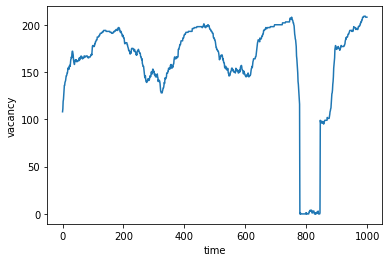

In [52]:
# idx = 12
# idx = 13
# idx = 17
idx = 100
path = '2022/garage_dataset'
m, n = 0, 1000
x = []
curve = []
size = len(os.listdir(path)) - 1
for i in tqdm(range(m, n)):
    i %= size
    x.append(i)
    data = torch.load(os.path.join(path, '%d.pt'%i))
    curve.append(data[idx])
    
plt.plot(x, curve)
plt.xlabel('time')
plt.ylabel('vacancy')

### Link Graph

In [13]:
f = open('2021/garage_index_filter.csv', 'r')
lines = f.read().splitlines()
f.close()

park_list = []

for line in lines:
    index, park, lat, lon = line.split(',')
    park_list.append((int(index), float(lat), float(lon)))
    
link_graph = np.eye(len(park_list), dtype=bool)
link_graph.shape

threshold = 0.01

for park in tqdm(park_list):
    i, lat, lon = park

    for neighbor in park_list[i:]:
        j, j_lat, j_lon = neighbor
        if ((lat - j_lat)**2 + (lon - j_lon)**2)**0.5 < threshold:
            link_graph[i, j] = True
            link_graph[j, i] = True
            

res = [[], []]

m, n = link_graph.shape

for i in tqdm(range(m)):
    for j in range(n):
        if link_graph[i, j] and i != j:
            res[0].append(i)
            res[1].append(j)
            
edge_graph = torch.tensor(res)

torch.save(edge_graph, '2021/garage_dataset_filter/link.pt')

100%|██████████| 77/77 [00:00<00:00, 76913.89it/s]


100%|██████████| 77/77 [00:00<00:00, 16642.35it/s]


(22.194, 22.554)

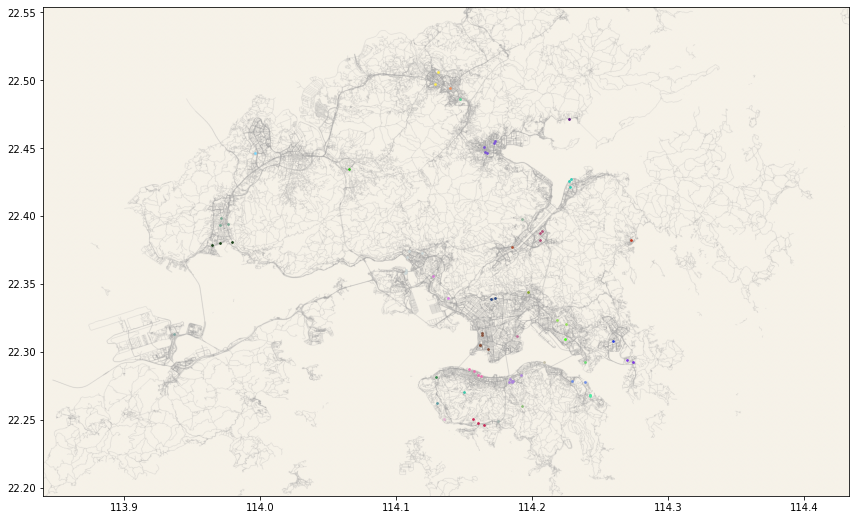

In [14]:
import random

visited = [0] * len(park_list)
group_list = []

def dfs(i, local):
    # print(len(local))
    local.append(i)
    for j, v in enumerate(link_graph[i]):
        if v == True and j != i and visited[j] == 0:
            visited[j] = 1
            dfs(j, local)

for i in tqdm(range(len(link_graph))[:]):
    if visited[i] == 0:
        local = []
        visited[i] = 1
        dfs(i, local)
        group_list.append(local)


plt.figure(figsize=(15, 9))
bg = plt.imread('hk.png')
plt.imshow(bg, extent=[113.84, 114.433, 22.194, 22.554])

for group in group_list:
    r = random.randint(16, 255)
    g = random.randint(16, 255)
    b = random.randint(16, 255)
    color = '#%x%x%x'%(r, g, b)
    
    lats = []
    lons = []
    
    for i in group:
        lat, lon = park_list[i][-2:]
        lats.append(lat)
        lons.append(lon)
        
    plt.scatter(lons, lats, c=color, s=3, linewidths=None, alpha=0.9)

plt.xlim(113.84, 114.433)
plt.ylim(22.194, 22.554)

### smooth

In [26]:
ga_dir = '2022/garage_dataset'
ga_list = []
 
for i in tqdm(range(len(os.listdir(ga_dir)) - 1)):
    ga = torch.load(os.path.join(ga_dir, '%d.pt'%i))
    ga_list.append(ga)

ga = torch.vstack(ga_list).numpy().astype(float)

time_len, ga_len = ga.shape

smooth_window = 20

new_ga = np.empty_like(ga)

for i in tqdm(range(ga_len)):
    
    plt.figure(figsize=(50, 20))
    raw_np = ga[:, i]
    plt.subplot(3, 1, 1)
    plt.plot(raw_np)
    
    smooth_np = np.convolve(raw_np, np.ones(smooth_window), 'valid') / smooth_window
    smooth_np = np.concatenate([np.ones(smooth_window - 1) * smooth_np[0], smooth_np])
    plt.subplot(3, 1, 2)
    plt.plot(smooth_np)

    
    raw_range = raw_np.max() - raw_np.min()
    smooth_np = raw_np.copy()
    flag = False
    for j in range(1, time_len):
        if raw_np[j - 1] - raw_np[j] > raw_range / 10:
            smooth_np[j] = raw_np[j - 1]
            flag = True
        elif flag and abs(raw_np[j] - raw_np[j - 1]) == 0:
            smooth_np[j] = smooth_np[j - 1]
        else:
            flag = False
    smooth_np = np.convolve(smooth_np, np.ones(smooth_window), 'valid') / smooth_window
    smooth_np = np.concatenate([np.ones(smooth_window // 2) * smooth_np[0], smooth_np, np.ones(smooth_window // 2) * smooth_np[-1]])[:time_len]
    
    new_ga[:, i] = smooth_np
    
    plt.subplot(3, 1, 3)
    plt.plot(smooth_np)
    
    plt.savefig('2022/garage_pic/%d.jpg'%i)
    plt.close()
    

100%|██████████| 136/136 [01:02<00:00,  2.16it/s]


In [27]:
for i in tqdm(range(time_len)):
    data = torch.from_numpy(new_ga[i])
    torch.save(data, '2022/garage_dataset_smooth/%d.pt'%i)
    
link = torch.load('2022/garage_dataset/link.pt')
torch.save(link, '2022/garage_dataset_smooth/link.pt')

100%|██████████| 33951/33951 [00:14<00:00, 2296.16it/s]


In [25]:
new_ga[:,3].mean()

81.12316881613758

## filter

In [9]:
filter = np.load('2021/white_list.npy')

f = open('2021/garage_index.csv', 'r')
lines = f.read().splitlines()
f.close()

park_list = []

for line, valid in zip(lines, filter):
    if valid:
        index, park, lat, lon = line.split(',')
        park_list.append((park, float(lat), float(lon)))
        
f = open('2021/garage_index_filter.csv', 'w')
for i, park in enumerate(park_list):
    f.write(str(i))
    f.write(',')
    f.write(','.join([str(x) for x in park]))
    f.write('\n')
f.close()

In [15]:
ga_dir = '2021/garage_dataset_smooth'
ga_list = []

for i in tqdm(range(len(os.listdir(ga_dir)) - 1)):
    ga = torch.load(os.path.join(ga_dir, '%d.pt'%i))[filter]
    torch.save(ga, '2021/garage_dataset_filter/%d.pt'%i)

100%|██████████| 24192/24192 [00:15<00:00, 1531.43it/s]
